In [56]:

# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import cv2
import random
import math
import glob
from tqdm import tqdm
import re
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, LSTM, Activation, AveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras import layers, regularizers,activations
from keras.utils import to_categorical,Sequence
from keras import optimizers, initializers, regularizers, metrics


# sklearn
from sklearn import svm
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso


import warnings
warnings.filterwarnings(action='ignore') 

In [57]:
# unzip data
# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/lettuce.zip" -d "/content/drive/MyDrive/Colab Notebooks/lettuce_pro"

In [58]:
# Load Dat from directory
data_dir = '../data/'

In [59]:
# set hyper parmeters
hyper_param = {
    'EPOCHS':500,
    'LEARNING_RATE':1e-2,   
    'BATCH_SIZE':24,        
    'SEED':2022
}

In [60]:
# # set seed
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)

# seed_everything(hyper_param['SEED'])

In [61]:
os.chdir('/Users/zzgr/Desktop/zzgrProject/상추')

In [62]:
# train data into list
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))
len(all_input_list), len(all_target_list)

(28, 28)

In [63]:
# split data - training(21) : validation(7)
train_input_list = all_input_list[:21]
train_target_list = all_target_list[:21]

val_input_list = all_input_list[21:]
val_target_list = all_target_list[21:]

print(f'training: {len(train_input_list)}, validation: {len(val_input_list)}')

training: 21, validation: 7


In [64]:
for input_path, target_path in tqdm(zip(train_input_list, train_target_list)):
    input_df = pd.read_csv(input_path)
    target_df = pd.read_csv(target_path)

21it [00:00, 274.02it/s]


In [11]:
input_df

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,00:00,22.086667,49.418333,671.416667,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
1,0,01:00,21.883050,50.208475,658.627119,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
2,0,02:00,21.781666,50.896667,644.700000,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
3,0,03:00,21.646667,51.531667,629.850000,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
4,0,04:00,21.563333,52.096667,615.166667,0.000000,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19:00,29.205000,81.221667,450.000000,0.881662,126.00,1121.14,18255.1900,254644.4300,9763.3200,136190.0400,9242.350,129079.600,37260.8600,519914.0700
668,27,20:00,29.370000,81.230000,441.383333,0.881711,0.00,1121.14,18255.1900,272899.6200,9763.3200,145953.3600,9242.350,138321.950,37260.8600,557174.9300
669,27,21:00,25.720000,83.621667,654.083333,0.884103,126.00,1247.14,754.9604,273654.5804,403.7712,146357.1312,382.226,138704.176,1540.9576,558715.8876
670,27,22:00,23.960000,83.541667,681.983333,0.895256,0.00,1247.14,0.0000,273654.5804,0.0000,146357.1312,0.000,138704.176,0.0000,558715.8876


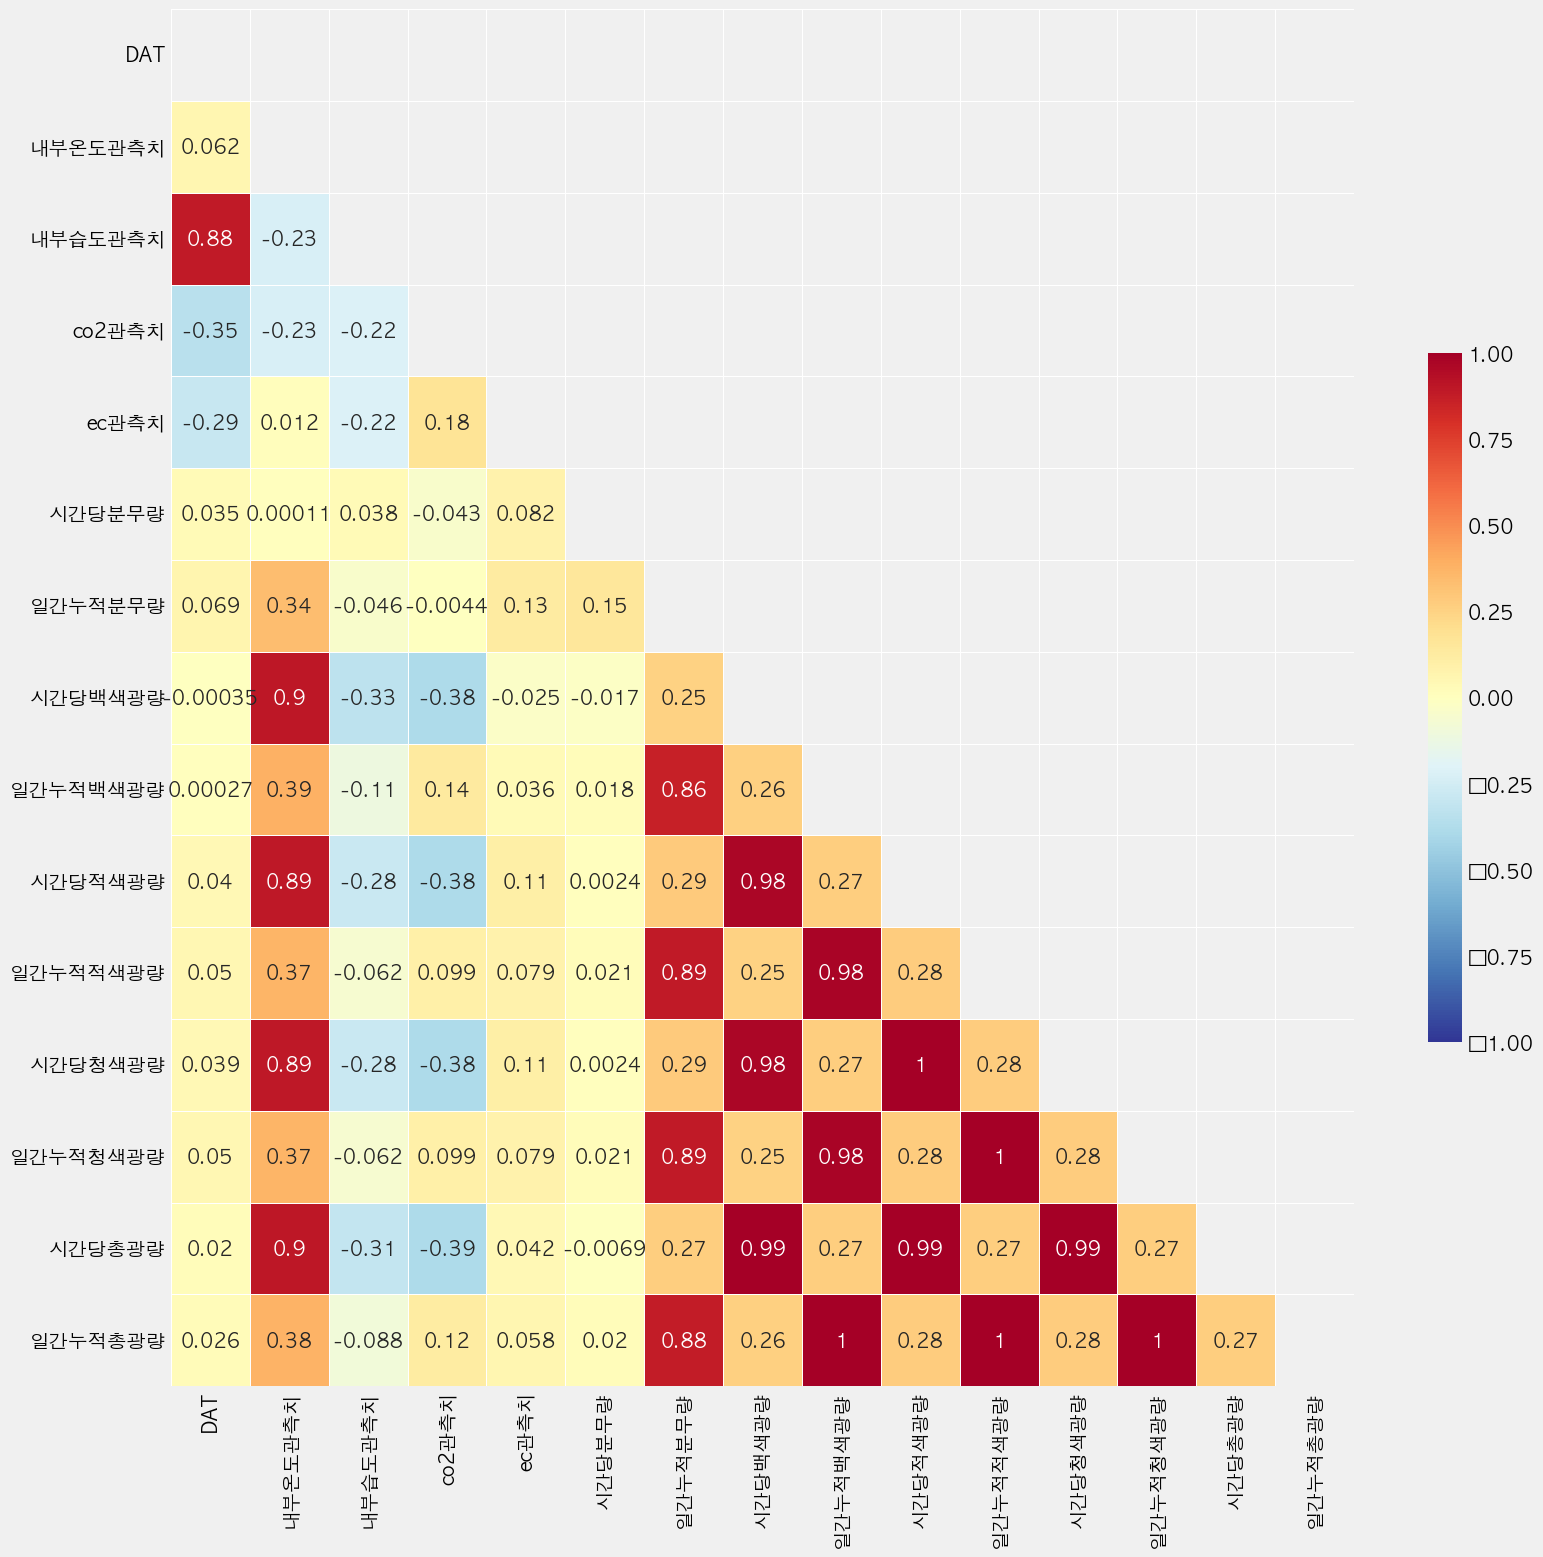

In [541]:
# 그림 사이즈 지정
plt.rcParams['font.family'] = 'AppleGothic'
fig, ax = plt.subplots( figsize=(17,17) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(cor, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [38]:
# make custom dataset using Sequence
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, input_paths, target_paths, batch_size, infer_mode, shuffle=False):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.batch_size = batch_size
        self.infer_mode = infer_mode
        self.shuffle = shuffle

        self.data_list = []
        self.label_list = []
        print('Data Pre-processing..')
        for input_path, target_path in tqdm(zip(self.input_paths, self.target_paths)):
            input_df = pd.read_csv(input_path)
            target_df = pd.read_csv(target_path)

            input_df = input_df.drop(columns=['obs_time'])
            input_df = input_df.fillna(0)

            target_length = int(len(target_df))
            
            ss = StandardScaler()
            ss.fit_transform(input_df)
            
            # for idx in range(1,target_length):
            #     for i in range(idx*24,(idx+1)*24):
                    
                    # input_df.iloc[i,1] += input_df.iloc[idx*24-1,1]
                    # input_df.iloc[i,2] += input_df.iloc[idx*24-1,2]
                    # input_df.iloc[i,3] += input_df.iloc[idx*24-1,3]
                    # input_df.iloc[i,4] += input_df.iloc[idx*24-1,4]
                    # input_df.iloc[i,5] += input_df.iloc[idx*24-1,5]
                    # input_df.iloc[i,6] += input_df.iloc[idx*24-1,6]
                    # input_df.iloc[i,7] += input_df.iloc[idx*24-1,7]
                    # input_df.iloc[i,8] += input_df.iloc[idx*24-1,8]
                    # input_df.iloc[i,9] += input_df.iloc[idx*24-1,9]
                    # input_df.iloc[i,10] += input_df.iloc[idx*24-1,10]
                    # input_df.iloc[i,11] += input_df.iloc[idx*24-1,11]
                    # input_df.iloc[i,12] += input_df.iloc[idx*24-1,12]
                    # input_df.iloc[i,13] += input_df.iloc[idx*24-1,13]
                    # input_df.iloc[i,14] += input_df.iloc[idx*24-1,14]

            for idx in range(target_length):
                time_series = input_df[24*idx:24*(idx+1)].values
                self.data_list.append(time_series)

            for label in target_df['predicted_weight_g']:
                self.label_list.append(label)
        print('Done. \n')
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.data_list)/self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        data = [self.data_list[i] for i in indices]
        label = [self.label_list[i] for i in indices]

        if self.infer_mode == False:
            return tf.convert_to_tensor(data), tf.convert_to_tensor(label)
        else:
            return tf.convert_to_tensor(data)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.data_list))

        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [66]:
# train data preprocessing 
train_loader = Dataloader(train_input_list, train_target_list, hyper_param['BATCH_SIZE'], False, shuffle=False)
val_loader = Dataloader(val_input_list, val_target_list, hyper_param['BATCH_SIZE'], False, shuffle=False)

Data Pre-processing..


0it [00:00, ?it/s]

28


ValueError: could not broadcast input array from shape (14,) into shape (350,)

In [53]:
class BaseModel(tf.keras.Model):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = tf.keras.layers.Bidirectional(LSTM(64))
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.lstm = tf.keras.layers.Bidirectional(LSTM(64))
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.lstm = tf.keras.layers.Bidirectional(LSTM(64))
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.lstm = tf.keras.layers.Bidirectional(LSTM(64))
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.classifier = tf.keras.layers.Dense(1)

    def call(self, inputs):
        h = self.lstm(inputs)
        return self.classifier(h)

In [54]:
# Compiling
model = BaseModel()
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=hyper_param['LEARNING_RATE']),
    loss=tf.keras.losses.MeanAbsoluteError(),
    # metrics=tf.keras.metrics.RootMeanSquaredError(name='rmse')
)

In [55]:
# Training & Evaluation
history = model.fit(
    train_loader, validation_data=val_loader, 
    epochs=hyper_param['EPOCHS'],
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-8)]
    )

model.evaluate(train_loader), model.evaluate(val_loader)

Epoch 1/500
25/25 [==============================] - 2s 27ms/step - loss: 36.1743 - val_loss: 19.8578 - lr: 0.0100
Epoch 2/500
25/25 [==============================] - 0s 9ms/step - loss: 33.9161 - val_loss: 19.4734 - lr: 0.0100
Epoch 3/500
25/25 [==============================] - 0s 10ms/step - loss: 33.0519 - val_loss: 19.3265 - lr: 0.0100
Epoch 4/500
25/25 [==============================] - 0s 9ms/step - loss: 32.5767 - val_loss: 19.2578 - lr: 0.0100
Epoch 5/500
25/25 [==============================] - 0s 9ms/step - loss: 32.1912 - val_loss: 19.4300 - lr: 0.0100
Epoch 6/500
25/25 [==============================] - 0s 9ms/step - loss: 31.9367 - val_loss: 19.5620 - lr: 0.0100
Epoch 7/500
25/25 [==============================] - 0s 9ms/step - loss: 31.7294 - val_loss: 19.5208 - lr: 0.0100
Epoch 8/500
25/25 [==============================] - 0s 9ms/step - loss: 31.6211 - val_loss: 19.6259 - lr: 0.0100
Epoch 9/500
25/25 [==============================] - 0s 9ms/step - loss: 31.4712 - val

KeyboardInterrupt: 

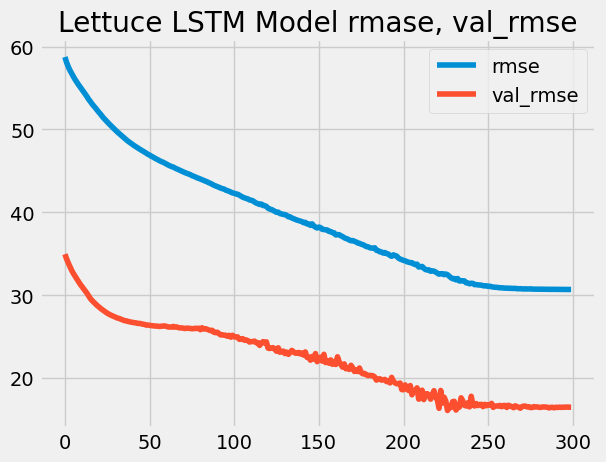

In [36]:
# Visualization
plt.style.use('fivethirtyeight')
plt.plot(history.history['rmse'],label='rmse')
plt.plot(history.history['val_rmse'],label='val_rmse')
plt.title('Lettuce LSTM Model rmase, val_rmse')
plt.legend()
plt.show()

In [ ]:
# test data into list
test_input_list = sorted(glob.glob('./test_input/*.csv'))
test_target_list = sorted(glob.glob('.//test_target/*.csv'))
len(test_input_list), len(test_target_list)

(5, 5)

In [ ]:
# test data preprocessing,  
for test_input_path, test_target_path in zip(test_input_list, test_target_list):
    print(test_target_path)
    test_loader = Dataloader([test_input_path], [test_target_path], hyper_param['BATCH_SIZE'], True, shuffle=False)
    model_pred = model.predict(test_loader)

    submit_df = pd.read_csv(test_target_path)
    submit_df['predicted_weight_g'] = model_pred
    submit_df.to_csv(test_target_path, index=False)

.//test_target/TEST_01.csv
Data Pre-processing..


1it [00:00,  4.64it/s]


Done. 

1/1 [==============================] - 0s 498ms/step
.//test_target/TEST_02.csv
Data Pre-processing..


1it [00:00,  4.10it/s]

Done. 

1/1 [==============================] - 0s 27ms/step


.//test_target/TEST_03.csv
Data Pre-processing..


1it [00:00,  4.98it/s]

Done. 

1/1 [==============================] - 0s 29ms/step


.//test_target/TEST_04.csv
Data Pre-processing..


1it [00:00,  5.00it/s]

Done. 

1/1 [==============================] - 0s 27ms/step


.//test_target/TEST_05.csv
Data Pre-processing..


1it [00:00,  5.05it/s]

Done. 



1/1 [==============================] - 0s 28ms/step


In [ ]:
submit_df

,DAT,predicted_weight_g
0,1,2.018500
1,2,2.600372
2,3,0.950670
3,4,2.260766
4,5,2.794451
5,6,3.610586
6,7,4.137151
7,8,5.240621
8,9,5.808766
9,10,6.944163


In [ ]:
# save submission to test_target directory
import zipfile
os.chdir("./open/test_target/")
submission = zipfile.ZipFile("jun99ri4.zip", 'w')
for path in test_target_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()

FileNotFoundError: [Errno 2] No such file or directory: './open/test_target/'